<a href="https://colab.research.google.com/github/nhatminhnb123/PythonAssignment/blob/main/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hướng dẫn, giải thích các bài tập trong (M5-Forecasting)

**Giới thiệu**
---
sử dụng dữ liệu bán hàng phân cấp được trích xuất để phân tích từ Walmart, công ty lớn nhất thế giới theo doanh thu và sử dụng nó để dự báo doanh số hàng ngày trong 28 ngày tới. Tập dữ liệu bán hàng chứa thông tin về khoảng 30.000 mặt hàng khác nhau trong gần 1900 ngày. Việc phân bổ dữ liệu đã được phân chia xung quanh và bao gồm các cửa hàng ở ba Tiểu bang Hoa Kỳ (California, Texas và Wisconsin) bao gồm cấp mặt hàng, bộ phận, danh mục mặt hàng và chi tiết cấp cửa hàng. Ngoài ra, nó có các biến số giải thích như giá cả, chương trình khuyến mãi, ngày trong tuần và các sự kiện đặc biệt. 


# Thêm các gói thư viện, dữ liệu mẫu

In [ ]:
import numpy as np # xư lý số 
import pandas as pd # xử lý dữ liệu
import matplotlib.pyplot as plt

import time
import math
import datetime


from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Mô tả tập dữ liệu**:  <br>
Mô tả các tệp dữ liệu được nhập: <br> 
calendar_df.csv: Chứa thông tin về ngày mặt hàng được bán và cũng chứa thông tin về các ngày lễ và dịp đặc biệt.<br>
train_sales_df.csv - Chứa dữ liệu lịch sử bán đơn vị hàng ngày cho mỗi mặt hàng và id cửa hàng và bộ phận với gần như dữ liệu bán hàng trong 1900 ngày [d_1 - d_1913] <br>
submit_file.csv - Định dạng chính xác cho tệp gửi, chứa id mặt hàng và cột id cho dự báo dữ liệu bán hàng 28 ngày tới. <br>
sell_prices_df.csv - Chứa thông tin về giá của các mặt hàng được bán trên mỗi cửa hàng và ngày. <br>
sales_train_evaluation.csv - Bao gồm doanh số bán hàng [d_1 - d_1941]

**Nhập tập dữ liệu**

In [ ]:
sell_prices_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sell_prices.csv')
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sales_train_validation.csv')
calendar_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/calendar.csv')

**Tổng quan dữ liệu**

In [ ]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [ ]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [ ]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


# EDA (Phân tích dữ liệu khám phá): 
<br>Dữ liệu được biểu thị qua biến train_sales_df có: mặt hàng cụ thể ('id'), địa phương cụ thể ('store_id', 'state_id') và ngày bán hàng cụ thể ( d_1 đến d_1913)

In [ ]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


**Tách các ngày bán hàng để chỉ có thể dễ dàng quan sát phân tích dọc theo item_id, store_id và dept_id trong các ngày bán hàng**

In [ ]:
# Tạo biến mảng d_cols chứa tên các cột có chứa d_
d_cols = [c for c in train_sales_df.columns if 'd_' in c]

# Tính tổng lượng bán các ngày (tính tổng các giá trị trong hàng) gán vào cột total_sales_all_days
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)

# Tính trung bình các giá trị trong hàng gán vào cột avg_sales_all_days
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)

# Tính trung bình các giá trị trong hàng được làm tròn đến số thập phân thứ nhất gán vào cột median_sales_all_days
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)

**Phân phối các loại mặt hàng theo id**

In [ ]:
# Nhóm các hàng có cột cat_id, đếm các phần tử cột id, đặt tên cột là total_entries
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')

# Tạo biểu dồ tròn trên biến df, số phần tử trên biểu đồ = số phần tử biến df, 
# tên phần tử tương ứng với trường cat_id, giá trị tương ứng vơi truồng total_entries dạng tỉ lệ
# plotly.express gọi hàm pie(vẽ biểu đồ tròn) gán vào fig kiểu figure
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
# Gọi hàm hiển thị
fig.show()

**Các mặt hàng bán chạy nhất**

In [ ]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')
fig.show()

**Tổng doanh thu các loại mặt hàng**

In [ ]:
# Nhóm các hàng có cột cat_id, đếm các phần tử cột id, đặt tên cột là total_entries gán vào biến df1
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')

# Nhóm các hàng có cột cat_id và state_id, tính tổng các phần tử cột total_sales_all_days, đặt tên cột là total_entries gán vào biến df2
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

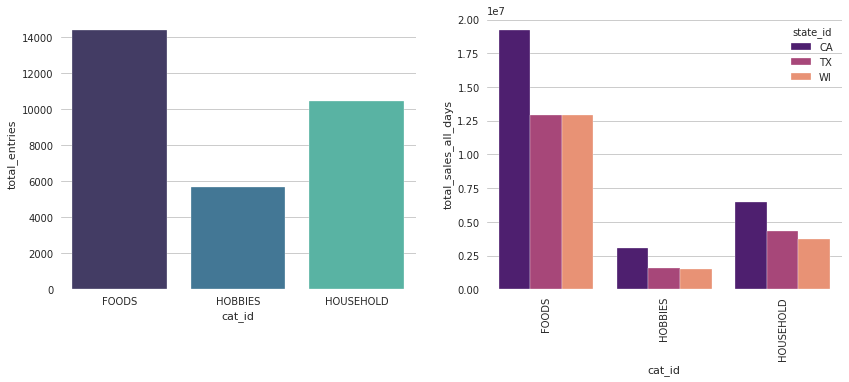

In [ ]:
# sns. gọi  thư viện seaborn

# Đặt phong cách chung, các tham số cố định cho ô
sns.set_style('whitegrid')
sns.axes_style(style='ticks')

# Tạo 2 biểu đồ (liền hàng 1 hàng, 2 cột, size 14,5)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

# cấu hình biểu đồ tham số (tên trục x, tên trục y, dữ liệu, kiểu giao diện, đối tượng axes ax1 và ax2)
sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

# xoay 90 tên cột
plt.xticks(rotation=90)
plt.show()

**Phân bổ các mặt hàng theo loại và khu vực**

In [ ]:
# Nhóm các hàng có cột state_id và cat_id, thêm cột đếm các phần tử cột id đặt tên num_sales_by_category
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')

# tạo biểu đồ biểu thị phần tử dạng thanh xếp chồng (tên hàng state_id, tên cột num_sales_by_category, 
# tên phụ lục cat_id, dữ liệu df, tiêu đề Distribution of Product_ids Count Across Categories & Each Locale)
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")

# hiển thị fig
fig.show()

**Phân bổ mặt hàng theo chi nhánh và cửa hàng**

In [ ]:
# Nhóm các hàng có cột ('dept_id', 'store_id', 'state_id', 'cat_id'),tính tổng các phần tử cột thứ 6 trở đi
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()

# sắp xếp giảm dần theo cột total_sales_all_days
df = df.sort_values('total_sales_all_days', ascending=False)

In [ ]:
# tạo biến
x_dept = df['dept_id']
x_store = df['store_id']

# tạo hàm items_sold_per_days 
# tham số (x_spec: dữ liệu, title_text: tiêu đề chung, title: tiêu đề trong phân loại)
# trả về

def items_sold_per_days(x_spec,title_text, title):
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')

**Danh sách cửa hàng bán chạy nhất**

In [ ]:
# Nhóm các hàng có cột ('id'), tính tổng các phần tử cột total_sales_all_days, sắp xếp giảm dần
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_1_001_CA_1_validation        0.0
HOUSEHOLD_1_032_CA_3_validation    0.0
HOUSEHOLD_1_033_TX_1_validation    0.0
HOUSEHOLD_1_033_CA_4_validation    0.0
HOUSEHOLD_1_033_CA_3_validation    0.0
                                  ... 
FOODS_3_403_WI_3_validation        0.0
FOODS_3_403_WI_2_validation        0.0
FOODS_3_403_WI_1_validation        0.0
FOODS_3_403_TX_3_validation        0.0
HOUSEHOLD_2_516_WI_3_validation    0.0
Name: total_sales_all_days, Length: 30490, dtype: float64

**Doanh số hàng ngày của 2 mặt hàng bán chạy nhất FOODS_3_090_CA_3_validation và FOODS_3_586_TX_2_validation**

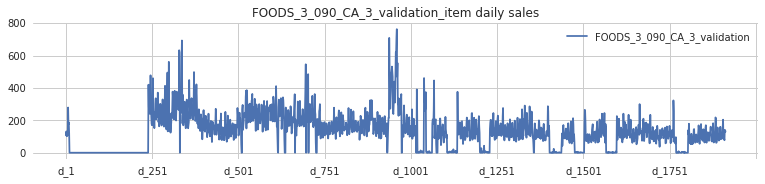

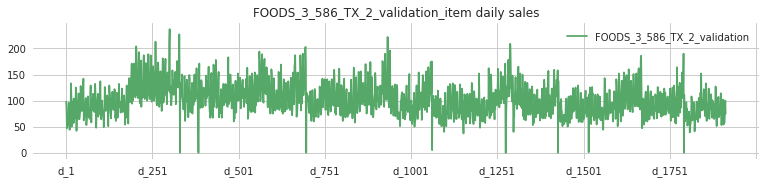

In [ ]:
sns.set_style('whitegrid')

# tạo làm lập biểu đồ buôn bán hàng ngày theo ids
# tham số spec_id
# trả về số lượng bán trong ngày
def plot_dailysales(spec_id):
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

**Id các mặt hàng bán được nhiều nhất theo mỗi loại**

In [ ]:
# Nhóm các hàng có cột ('id', 'cat_id', 'store_id'), tính tổng các phần tử cột total_sales_all_days, sắp xếp giảm dần
# Ép kiểu sang dataframe gán vào biến df_agg
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))

# đặt lại chỉ mục
df_agg = df_agg.reset_index()

# hiện 3 phần tử đầu df_agg
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_1_001_CA_1_validation,FOODS,CA_1,0.0
1,HOUSEHOLD_1_032_CA_3_validation,HOUSEHOLD,CA_3,0.0
2,HOUSEHOLD_1_033_TX_1_validation,HOUSEHOLD,TX_1,0.0


**3 mặt hàng bán được nhiều nhất của mỗi loại**

In [ ]:
# format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])) 
# format theo kiểu list
# truy cập vào hàng có giá trị 'cat_id' = FOODS, lấy phần từ cột 'id', lấy 3 hàng đầu 

print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_1_001_CA_1_validation', 'FOODS_1_001_CA_2_validation', 'FOODS_2_293_WI_1_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_032_CA_3_validation', 'HOUSEHOLD_1_033_TX_1_validation', 'HOUSEHOLD_1_033_CA_4_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_2_148_WI_3_validation', 'HOBBIES_2_149_WI_3_validation', 'HOBBIES_2_149_WI_2_validation']


**Biểu đồ hồi quy** <br>
Thể hiện sản lượng bán được của 3 sản phẩm được quan sát từ ngày thứ 500 đến ngày thứ 900

In [ ]:
# vẽ biểu đồ dữ liệu bán hàng theo điểm trong khoảng thời gian và điểm mẫu được chọn
# tham số: spec_id (id mặt hàng), sm_start (thời điểm bắt đầu), sm_end (thời điểm kết thúc), samples_pick(thời điểm mẫu được chọn)
# biểu đồ 
def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    # vẽ biểu đồ hồi quy tuyến tính 
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

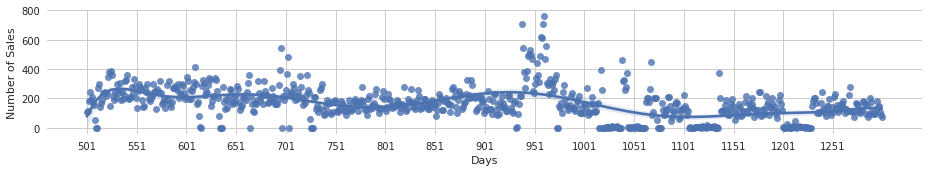

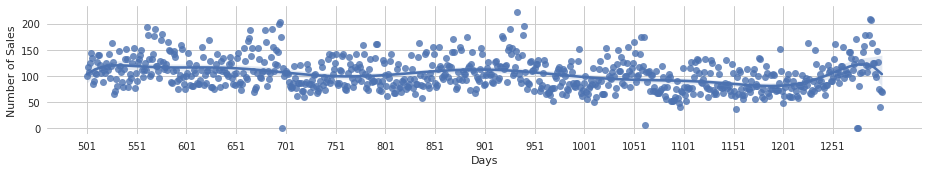

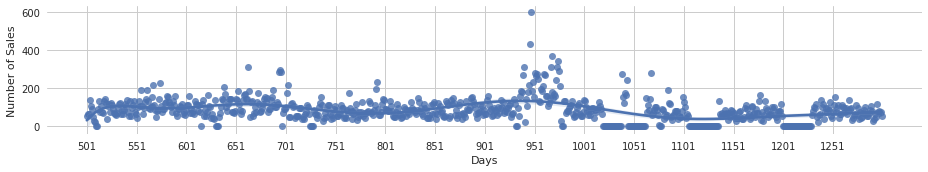

In [ ]:
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

# Doanh thu bán hàng

In [ ]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# tạo cột mới từ item_id
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

**Phân phối giá giữa các loại**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<Figure size 1080x360 with 0 Axes>

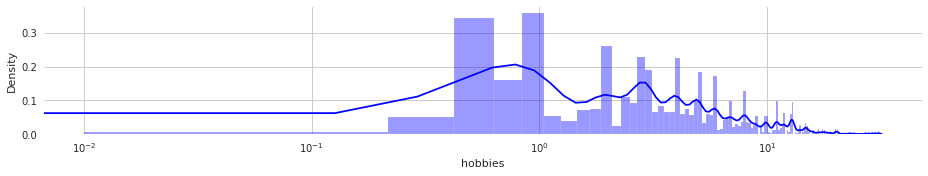

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



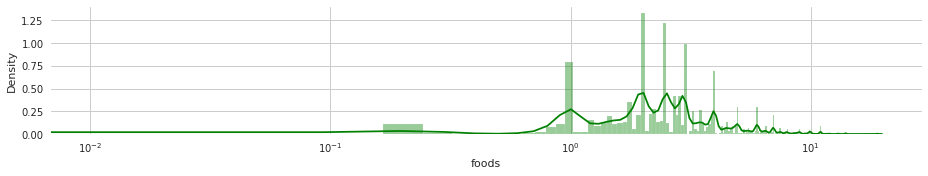

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



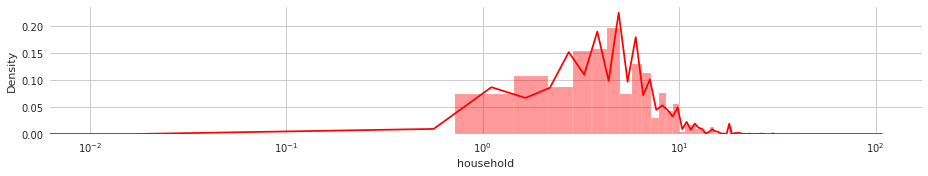

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

**Loại bỏ các yếu tố ngoại lai để quan sát phân phối giá**
<br>Phương pháp quantile 

In [ ]:
def remove_outliers(df):
  
    # xóa phần tử ngoại lệ trong hàm liên tục, sử dụng quartile
    # tham số: df
    # trả về: df đã xóa phần từ ngoại lệ
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



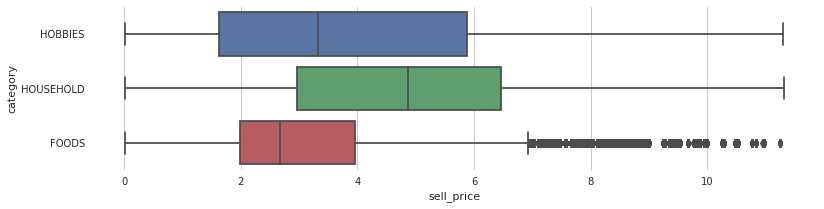

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

**Doanh số bán được trong dịp đặc biệt và ngày cuối tuần**

In [ ]:
calendar_df.head(3)

In [ ]:
# nhóm cột event_name_1, event_type_1, đếm theo cột wday 
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

In [ ]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

In [ ]:
# lấy ra ngày trong cột date
calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
# lấy ra events_names với events_types qua hợp từ 4 cột
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)

In [ ]:
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

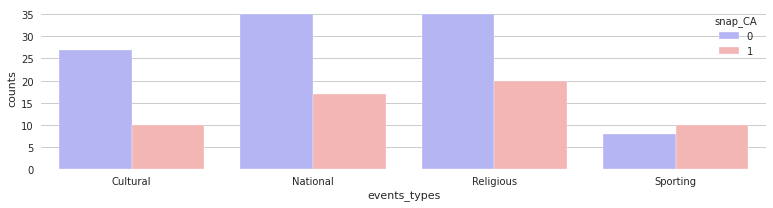

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

**SNAP_CA, SNAP_TX, SNAP_WI**<br>
SNAP là viết tắt của "Chương trình hỗ trợ dinh dưỡng bổ sung". Chương trình này hướng tới việc cung cấp các thực phẩm thiết yếu và trong tập dữ liệu hiện tại, danh mục các vật dụng gia đình và các vật dụng sở thích không nằm trong các yêu cầu của chương trình này.

In [ ]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

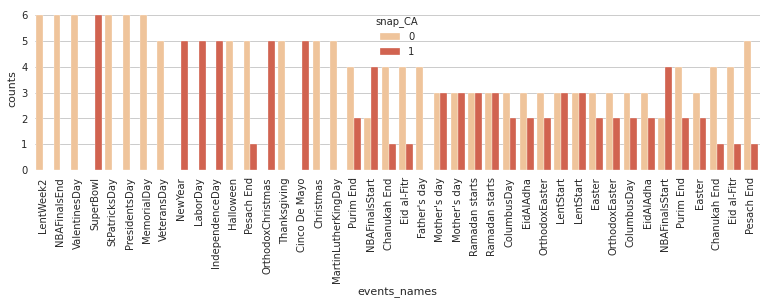

In [ ]:
  sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))

# vẽ biểu đồ đếm snap_SA trên cột events_names, sắp xếp giảm dần
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

**Phân phối các mặt hàng bán hàng với doanh thu bán hàng**<br>
Hợp nhất 2 tập dữ liệu train_sales_df và sell_prices_df 

In [ ]:
# join 2 bảng kiểu inner
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', 
                                            left_index=True, right_index=True, 
                                            validate="1:1")

In [ ]:
# tính tổng doanh thu theo từng vùng, từng loại, từng cửa hàng
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
# xắp xếp giảm dần theo tổng doanh thu
df = df.sort_values(by='total_revenue', ascending=False)

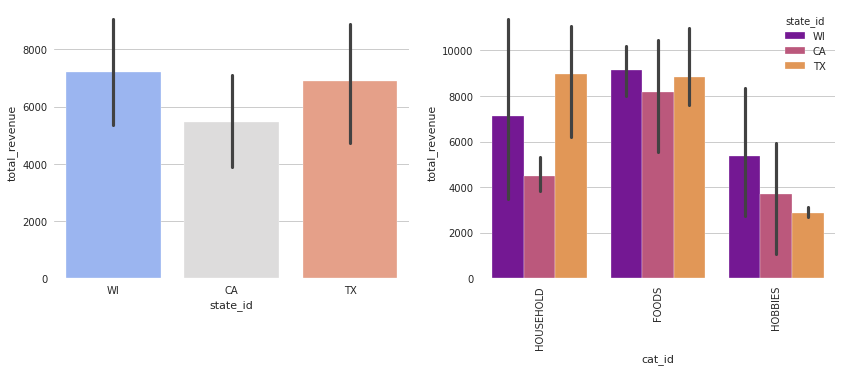

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

# biểu đồ tổng doanh thu theo vùng
sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
# biểu đồ tổng doanh thu theo loại mặt hàng 
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

# Behaviour on TimeSeries & Analysis?
Tìm hiểu doanh số bán hàng theo thời gian và những tác động như ngày cuối tuần hay các dịp đặc biệt đối với số lượng bán được<br>
**Rolling Averages**

Là một công cụ hữu ích để sử dụng để hiểu về những ảnh hưởng lâu dài trong timeseries. Cơ sở lý luận đằng sau việc sử dụng trung bình cuộn là việc đọc kết quả từ của nó giúp làm mượt dữ liệu so với những biến động hàng ngày

**Phân bổ tổng doanh số theo thời gian**

In [ ]:
#chuyển kiểu trong date ở calendar_df sang datetime
calendar_df.date = pd.to_datetime(calendar_df.date)
type(calendar_df.date)

pandas.core.series.Series

In [ ]:
# tạo bảng chi tiết các mặt hàng bán theo ngày 
# đặt chỉ mục của bảng train_sales_df có giá trị trong d_cols
# hợp train_sales_df với calendar_df theo chỉ mục 
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
# tính tổng các lượng bán theo ngày (cộng dồn hàng)                                                                    
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [ ]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [ ]:
# vẽ biểu đồ tổng lượng mặt hàng bán trong khoảng thời gian
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

# cấu hình chi tiết biểu đồ
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()

**Mulitplicative seasonality**<br>
Sử dụng mô-đun season_decompose trong mô hình thống kê để tìm ra các mẫu xu hướng trong khoảng thời gian.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
    
def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

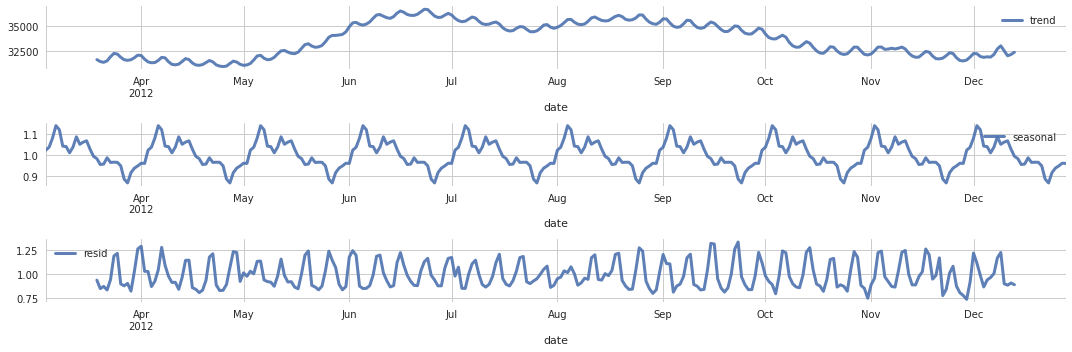

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

**Để quan sát tính thời vụ, lấy một tập hợp con của tập dữ liệu để quan sát**

In [ ]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [ ]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

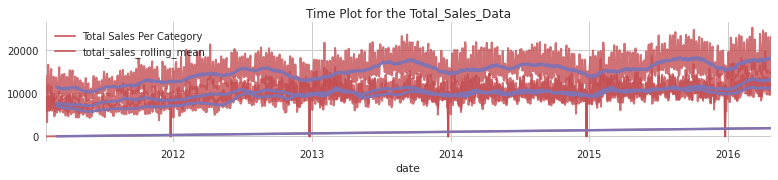

In [ ]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

**Biểu đồ doanh số của một vài mặt hàng để quan sát trong suốt dòng thời gian.**

In [ ]:
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_1_001_CA_1_validation,0.0
1,HOUSEHOLD_1_032_CA_3_validation,0.0
2,HOUSEHOLD_1_033_TX_1_validation,0.0
3,HOUSEHOLD_1_033_CA_4_validation,0.0
4,HOUSEHOLD_1_033_CA_3_validation,0.0


In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

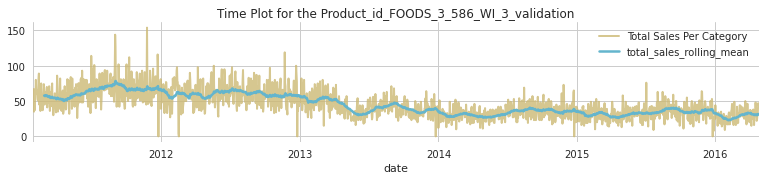

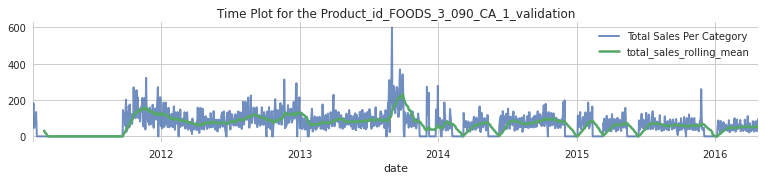

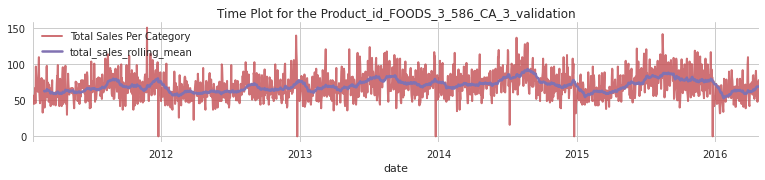

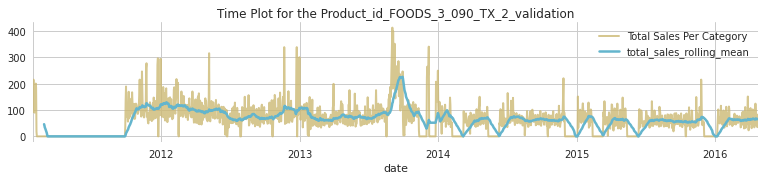

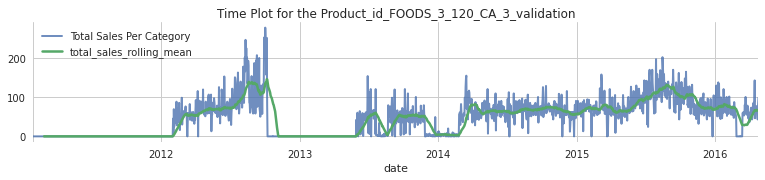

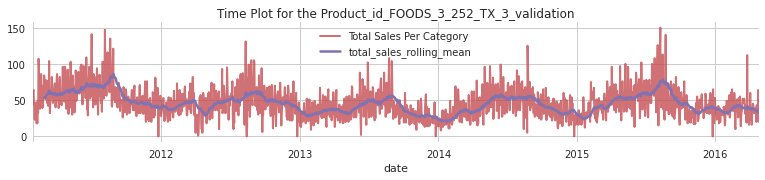

In [ ]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

**Phân bổ tổng doanh số đối với mỗi loại?**

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,total_sales
date,
2011-01-29,32631
2011-01-30,31749


In [ ]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

**Phân bổ tổng doanh số đã bán cho mỗi tiểu bang**

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,index,date,CA,TX,WI
0,0,2011-01-29,14195,9438,8998
1,1,2011-01-30,13805,9630,8314
2,2,2011-01-31,10108,6778,6897
3,3,2011-02-01,11047,7381,6984
4,4,2011-02-02,9925,5912,3309
...,...,...,...,...,...
1908,1908,2016-04-20,15148,9600,10595
1909,1909,2016-04-21,14488,9602,10943
1910,1910,2016-04-22,17095,10615,12807
1911,1911,2016-04-23,21834,12266,14862


In [ ]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

**Theo dõi việc bán các danh mục trên các tiểu bang riêng biệt**

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum().T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
train_sales_cal_df = train_sales_cal_df.set_index('dates')

In [ ]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum()
#train_sales_cal_df = 
df_CA = train_sales_cal_df[select_cols_ca]
df_TX = train_sales_cal_df[select_cols_tx]
df_WI = train_sales_cal_df[select_cols_wi]

df_CA.columns = [col[1] for col in df_CA.columns]
df_TX.columns = [col[1] for col in df_TX.columns]
df_WI.columns = [col[1] for col in df_WI.columns]

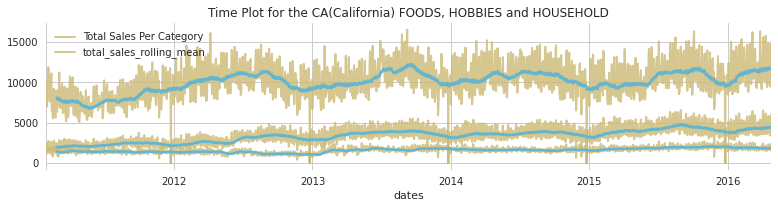

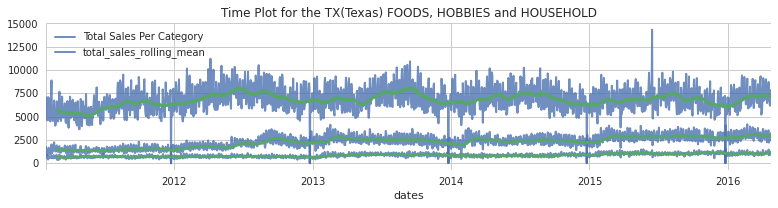

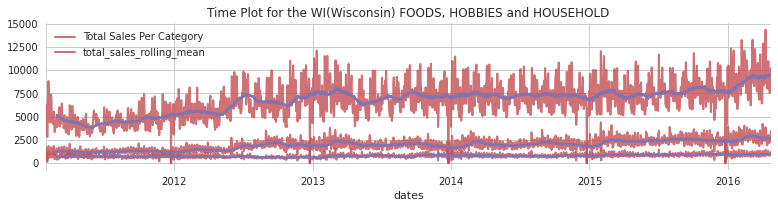

In [ ]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

**5 mặt hàng đã được bán nhiều nhất ở các địa điểm California và Texas.**

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [ ]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


**Doanh số theo cửa hàng**

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum()\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

**Phân bổ doanh số bán hàng theo ngày/cuối tuần cụ thể**

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')

In [ ]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

**Biểu đồ nhiệt doanh số bán hàng theo loại với ngày/cuối tuần cụ thể**

In [ ]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')